<a href="https://colab.research.google.com/github/yuliyabohdan/Facial-Keypoint-Detection/blob/main/face_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
%cd /content/gdrive/My Drive/Colab/Search_for_key_points_on_the_face

/content/gdrive/My Drive/Colab/Search_for_key_points_on_the_face


In [14]:
!pip install pretrainedmodels

In [15]:
!jupyter nbconvert --to script config.ipynb
!jupyter nbconvert --to script utils.ipynb
!jupyter nbconvert --to script model.ipynb
!jupyter nbconvert --to script dataset.ipynb

[NbConvertApp] Converting notebook config.ipynb to script
[NbConvertApp] Writing 428 bytes to config.py
[NbConvertApp] Converting notebook utils.ipynb to script
[NbConvertApp] Writing 2027 bytes to utils.py
[NbConvertApp] Converting notebook model.ipynb to script
[NbConvertApp] Writing 1367 bytes to model.py
[NbConvertApp] Converting notebook dataset.ipynb to script
[NbConvertApp] Writing 2889 bytes to dataset.py


In [16]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
import config
import utils
import dataset
from model import FaceKeypointResNet50
from dataset import train_data, train_loader, valid_data, valid_loader
from tqdm import tqdm
matplotlib.style.use('ggplot')

import copy
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread
import torch.nn as nn
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader

In [ ]:
key_pts_frame = pd.read_csv('train.csv')
key_pts_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5000 non-null   object
 1   x1        5000 non-null   int64 
 2   y1        5000 non-null   int64 
 3   x2        5000 non-null   int64 
 4   y2        5000 non-null   int64 
 5   x3        5000 non-null   int64 
 6   y3        5000 non-null   int64 
 7   x4        5000 non-null   int64 
 8   y4        5000 non-null   int64 
 9   x5        5000 non-null   int64 
 10  y5        5000 non-null   int64 
 11  x6        5000 non-null   int64 
 12  y6        5000 non-null   int64 
 13  x7        5000 non-null   int64 
 14  y7        5000 non-null   int64 
 15  x8        5000 non-null   int64 
 16  y8        5000 non-null   int64 
 17  x9        5000 non-null   int64 
 18  y9        5000 non-null   int64 
 19  x10       5000 non-null   int64 
 20  y10       5000 non-null   int64 
 21  x11       5000

In [ ]:
key_pts_frame.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,74,61,69,79,72,130,68,145,65,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,39,32,39,43,41,66,33,73,29,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,71,50,66,69,66,127,58,139,56,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,210,203,198,249,210,380,196,425,181,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,25,24,25,29,25,48,26,55,24,59,23,39,43,31,56,41,56,49,55


In [ ]:
key_pts_frame.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,74,61,69,79,72,130,68,145,65,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,39,32,39,43,41,66,33,73,29,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,71,50,66,69,66,127,58,139,56,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,210,203,198,249,210,380,196,425,181,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,25,24,25,29,25,48,26,55,24,59,23,39,43,31,56,41,56,49,55


In [ ]:
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  05317.jpg
Landmarks shape:  (14, 2)
First 4 key pts: [[ 25.  55.]
 [ 63.  39.]
 [145.  36.]
 [171.  45.]]


In [ ]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

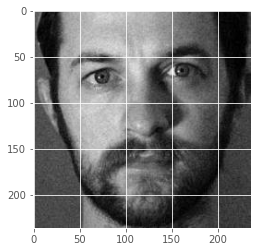

In [ ]:
img=imread(os.path.join('train', key_pts_frame['filename'][123]))
plt.imshow(img)
plt.show()

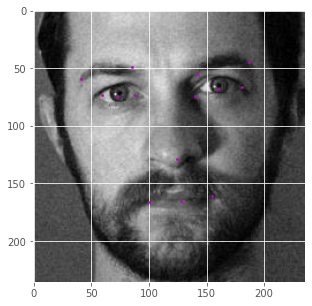

In [ ]:
n = 123
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))

show_keypoints(imread(os.path.join('train', key_pts_frame['filename'][n])), key_pts)

In [17]:
# model 
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(config.DEVICE)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=config.LR)
# we need a loss function MSELoss
criterion = nn.MSELoss()

Training intermediate layer parameters...


In [18]:
model.l0 = nn.Linear(2048, 28)

In [19]:
# training function
def fit(model, dataloader, data):
  print('Training')
  model.train()
  train_running_loss = 0.0
  counter = 0
  # calculate the number of batches
  num_batches = int(len(data)/dataloader.batch_size)
  for i, data in tqdm(enumerate(dataloader), total=num_batches):
      counter += 1
      image, keypoints = data['image'].to(config.DEVICE), data['keypoints'].to(config.DEVICE)
      # flatten the keypoints
      keypoints = keypoints.view(keypoints.size(0), -1)
      optimizer.zero_grad()
      outputs = model(image)
      loss = criterion(outputs, keypoints)
      train_running_loss += loss.item()
      loss.backward()
      optimizer.step()
      
  train_loss = train_running_loss/counter
  return train_loss


In [20]:
# validation function
def validate(model, dataloader, data, epoch):
  print('Validating')
  model.eval()
  valid_running_loss = 0.0
  counter = 0
  # calculate the number of batches
  num_batches = int(len(data)/dataloader.batch_size)
  with torch.no_grad():
      for i, data in tqdm(enumerate(dataloader), total=num_batches):
          counter += 1
          image, keypoints = data['image'].to(config.DEVICE), data['keypoints'].to(config.DEVICE)
          # flatten the keypoints
          keypoints = keypoints.view(keypoints.size(0), -1)
          outputs = model(image)
          loss = criterion(outputs, keypoints)
          valid_running_loss += loss.item()
          # plot the predicted validation keypoints after every...
          # ... predefined number of epochs
          if (epoch+1) % 1 == 0 and i == 0:
              utils.valid_keypoints_plot(image, outputs, keypoints, epoch)
      
  valid_loss = valid_running_loss/counter
  return valid_loss

In [ ]:
train_loss = []
val_loss = []
for epoch in range(config.EPOCHS):
    print(f"Epoch {epoch+1} of {config.EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

torch.save({
            'epoch': config.EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f"{config.OUTPUT_PATH}/model.pth")
print('DONE TRAINING')

  

Epoch 1 of 20
Training


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
141it [1:09:05, 29.40s/it]


Validating


16it [03:27, 12.94s/it]


Train Loss: 11162.2629
Val Loss: 10992.3990
Epoch 2 of 20
Training


141it [51:02, 21.72s/it]


Validating


16it [01:34,  5.92s/it]


Train Loss: 10893.0895
Val Loss: 10841.6439
Epoch 3 of 20
Training


141it [51:39, 21.98s/it]


Validating


16it [01:35,  5.98s/it]


Train Loss: 10593.3865
Val Loss: 10488.3840
Epoch 4 of 20
Training


141it [51:39, 21.98s/it]


Validating


16it [01:37,  6.07s/it]


Train Loss: 10294.9548
Val Loss: 10173.6645
Epoch 5 of 20
Training


141it [51:35, 21.95s/it]


Validating


16it [01:35,  5.98s/it]


Train Loss: 10012.8543
Val Loss: 9838.2069
Epoch 6 of 20
Training


141it [52:02, 22.14s/it]


Validating


16it [01:36,  6.01s/it]


Train Loss: 9746.8403
Val Loss: 9613.4161
Epoch 7 of 20
Training


141it [51:48, 22.05s/it]


Validating


16it [01:36,  6.02s/it]


Train Loss: 9490.8737
Val Loss: 9282.1270
Epoch 8 of 20
Training


141it [52:08, 22.18s/it]


Validating


16it [01:37,  6.08s/it]


Train Loss: 9240.5905
Val Loss: 9088.8398
Epoch 9 of 20
Training


141it [52:09, 22.19s/it]


Validating


16it [01:36,  6.03s/it]


Train Loss: 8998.5263
Val Loss: 8909.4197
Epoch 10 of 20
Training


141it [51:51, 22.07s/it]


Validating


16it [01:35,  5.95s/it]


Train Loss: 8760.5915
Val Loss: 8687.4186
Epoch 11 of 20
Training


141it [51:55, 22.10s/it]


Validating


16it [01:35,  5.95s/it]


Train Loss: 8528.9393
Val Loss: 8500.4015
Epoch 12 of 20
Training


141it [51:48, 22.05s/it]


Validating


16it [01:34,  5.93s/it]


Train Loss: 8301.8986
Val Loss: 8019.4107
Epoch 13 of 20
Training


141it [52:22, 22.29s/it]


Validating


16it [01:34,  5.93s/it]


Train Loss: 8081.2938
Val Loss: 7845.5889
Epoch 14 of 20
Training


141it [52:45, 22.45s/it]


Validating


16it [01:35,  5.96s/it]


Train Loss: 7863.7506
Val Loss: 7765.0911
Epoch 15 of 20
Training


141it [51:47, 22.04s/it]


Validating


16it [01:34,  5.93s/it]


Train Loss: 7648.5741
Val Loss: 7501.4405
Epoch 16 of 20
Training


141it [52:04, 22.16s/it]


Validating


16it [01:34,  5.93s/it]


Train Loss: 7438.0852
Val Loss: 7302.2370
Epoch 17 of 20
Training


141it [52:35, 22.38s/it]


Validating


16it [01:36,  6.06s/it]


Train Loss: 7233.3868
Val Loss: 7133.9842
Epoch 18 of 20
Training


141it [52:22, 22.29s/it]


Validating


16it [01:36,  6.00s/it]


Train Loss: 7027.4049
Val Loss: 6773.4127
Epoch 19 of 20
Training


141it [52:34, 22.38s/it]


Validating


16it [01:36,  6.01s/it]


Train Loss: 6795.6854
Val Loss: 6715.6602
Epoch 20 of 20
Training


141it [52:21, 22.28s/it]


Validating


16it [01:35,  5.98s/it]


Train Loss: 6593.8793
Val Loss: 6494.4505
DONE TRAINING


In [ ]:
torch.save({
            'epoch': config.EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f"{config.OUTPUT_PATH}/model.pth")
print('DONE TRAINING')

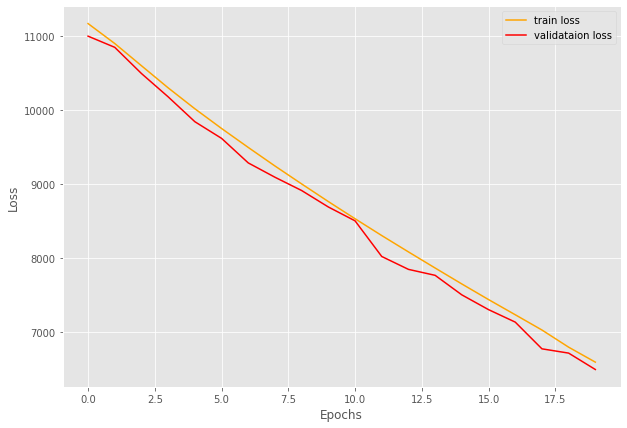

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"{config.OUTPUT_PATH}/loss.png")
plt.show()

In [24]:
checkpoint = torch.load('outputs/model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

FaceKeypointResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [58]:
path = 'test'
test_keypoints = []
image_list = []
for img in os.listdir('test'):
  with torch.no_grad():  
    image = imread(f"{path}/{img}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    orig_frame = image.copy()
    orig_h, orig_w, c = orig_frame.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float)
    image = image.unsqueeze(0).to(config.DEVICE)
    outputs = model(image)
  outputs = outputs.cpu().detach().numpy()
  outputs = outputs.reshape(-1, 2)
  keypoints = outputs

  test_keypoints.append(keypoints)
  image_list.append(img)


In [143]:
test = pd.DataFrame.from_records(test_keypoints)
test.shape

(1000, 14)

In [144]:
for column in test.columns:
  test[str('x'+ str(column+1))] = test[column][0][0]
  test['y'+ str(column+1)] = test[column][0][1]

In [145]:
test = test.drop(test.columns[0:14], 1)
#test['filename'] = image_list

In [146]:
test.insert(0, 'filename', image_list)

In [150]:
test.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00029.jpg,12.006166,19.377846,17.157728,12.559436,36.116447,21.404409,45.989471,11.029432,8.892033,19.701456,14.628884,13.411066,19.138893,24.406431,31.652533,18.140705,41.31958,23.141539,44.971302,15.987866,36.109371,36.525871,16.597509,37.545311,27.017542,37.044849,32.831604,44.03545
1,00023.jpg,12.006166,19.377846,17.157728,12.559436,36.116447,21.404409,45.989471,11.029432,8.892033,19.701456,14.628884,13.411066,19.138893,24.406431,31.652533,18.140705,41.31958,23.141539,44.971302,15.987866,36.109371,36.525871,16.597509,37.545311,27.017542,37.044849,32.831604,44.03545
2,00014.jpg,12.006166,19.377846,17.157728,12.559436,36.116447,21.404409,45.989471,11.029432,8.892033,19.701456,14.628884,13.411066,19.138893,24.406431,31.652533,18.140705,41.31958,23.141539,44.971302,15.987866,36.109371,36.525871,16.597509,37.545311,27.017542,37.044849,32.831604,44.03545
3,00017.jpg,12.006166,19.377846,17.157728,12.559436,36.116447,21.404409,45.989471,11.029432,8.892033,19.701456,14.628884,13.411066,19.138893,24.406431,31.652533,18.140705,41.31958,23.141539,44.971302,15.987866,36.109371,36.525871,16.597509,37.545311,27.017542,37.044849,32.831604,44.03545
4,00015.jpg,12.006166,19.377846,17.157728,12.559436,36.116447,21.404409,45.989471,11.029432,8.892033,19.701456,14.628884,13.411066,19.138893,24.406431,31.652533,18.140705,41.31958,23.141539,44.971302,15.987866,36.109371,36.525871,16.597509,37.545311,27.017542,37.044849,32.831604,44.03545


In [151]:
test.to_csv('test_keypoints.csv', sep='\t')